Visualization of some of the autocalibration channels.

Useful for others to see how we pick and choose pieces from the pipeline for use in a Jupyter notebook for prototyping and visualizations.

In [2]:
%matplotlib inline

import numpy as np

import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt

from sdo.datasets.dimmed_sdo_dataset import DimmedSDO_Dataset
from sdo.models.autocalibration1 import Autocalibration1
from sdo.pytorch_utilities import init_gpu, set_seed, create_dataloader

In [6]:
num_channels = 7
instruments = [
  "AIA",
  "AIA",
  "AIA",
  "AIA",
  "AIA",
  "AIA",
  "AIA"
]
wavelengths = [
  "0094",
  "0131",
  "0171",
  "0193",
  "0211",
  "0304",
  "0335"
]
yr_range = [2012, 2013]
actual_resolution = 512
subsample = 4
scaling = False
norm_by_orig_img_max = False
norm_by_dimmed_img_max = True

batch_size_train = 1
dataloader_workers = 6

scaled_height = 128
scaled_width = 128

In [7]:
cuda_device = 0
device = init_gpu(cuda_device)
set_seed()

In [9]:
train_dataset = DimmedSDO_Dataset(num_channels,
                                  instr=instruments,
                                  channels=wavelengths, yr_range=yr_range,
                                  resolution=actual_resolution,
                                  subsample=subsample,
                                  normalization=0, scaling=scaling,
                                  norm_by_orig_img_max=norm_by_orig_img_max,
                                  norm_by_dimmed_img_max=norm_by_dimmed_img_max,
                                  return_random_dim=False)
train_loader = create_dataloader(train_dataset, batch_size_train, dataloader_workers,
                                 train=True)

In [10]:
model = Autocalibration1(input_shape=[num_channels, scaled_height,
                         scaled_width], output_dim=num_channels)
model.cuda(device)
model.eval()

Autocalibration1(
  (_conv2d1): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1))
  (_conv2d2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (_fc1): Linear(in_features=21632, out_features=256, bias=True)
  (_fc2): Linear(in_features=256, out_features=7, bias=True)
)

In [19]:
examples = enumerate(train_loader)
batch_idx, (input_data, gt_output, normed_orig_data) = next(examples)

input_data = input_data.to(device)
gt_output = gt_output.to(device)
output = model(input_data)
output = output.to(device)

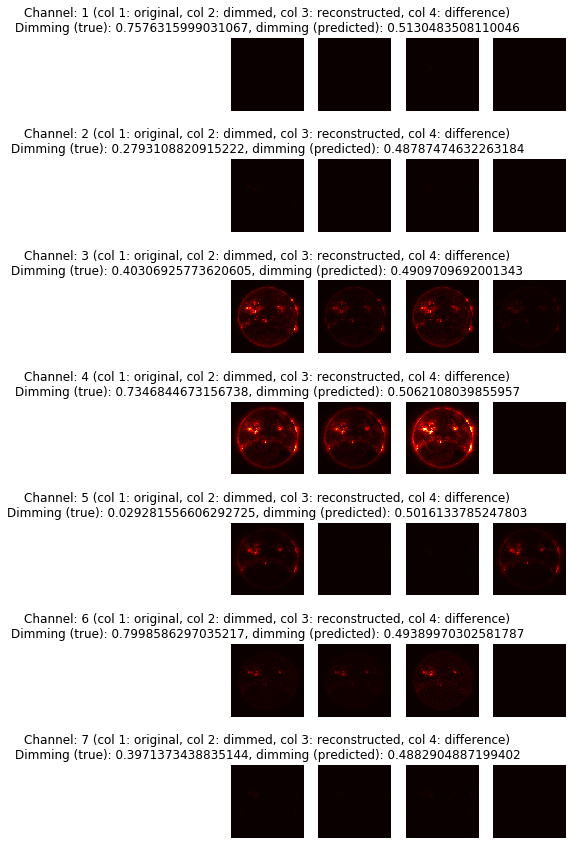

In [28]:
scale_min = 0
scale_max = normed_orig_data.max()

sample = normed_orig_data[0].cpu().numpy()
sample_dimmed = input_data[0].cpu().numpy()

# TODO: These images don't look correct; our channel 1 original image is dim, which is wrong.
# our channel. Col 2 dimming image looks completely black. Things don't look great.
fig = plt.figure()
pos = 0
for i, (channel_orig, channel_dimmed) in enumerate(zip(sample, sample_dimmed)):
    pos += 1
    pred_channel_dim_factor = float(output[0, i])
    # Reconstructed means we want to apply some transformation to the dimmed image
    # to get back the original undimmed image.
    reconstructed_channel = channel_dimmed / pred_channel_dim_factor

    ax1 = fig.add_subplot(num_channels, 4, pos)
    fig.subplots_adjust(top=3.0)
    ax1.set_title(
        'Channel: {} (col 1: original, col 2: dimmed, col 3: reconstructed, col 4: difference)\n'
        'Dimming (true): {}, dimming (predicted): {}'.format(i+1, gt_output[0, i],
                                                             pred_channel_dim_factor))
    ax1.axis('off')
    ax1.imshow(channel_orig, norm=None, cmap='hot', vmin=scale_min, vmax=scale_max)

    pos += 1
    ax2 = fig.add_subplot(num_channels, 4, pos)
    ax2.axis('off')
    ax2.imshow(channel_dimmed, norm=None, cmap='hot', vmin=scale_min, vmax=scale_max)

    pos += 1
    ax3 = fig.add_subplot(num_channels, 4, pos)
    ax3.axis('off')
    ax3.imshow(reconstructed_channel, norm=None, cmap='hot', vmin=scale_min,
               vmax=scale_max)

    # See the difference of how well we reconstructed a dimmed image vs. the actual original
    # non-degraded image.
    pos += 1
    ax4 = fig.add_subplot(num_channels, 4, pos)
    ax4.axis('off')
    channel_diff = channel_orig - reconstructed_channel
    ax4.imshow(channel_diff, norm=None, cmap='hot', vmin=scale_min, vmax=scale_max)

plt.show()